In [101]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
import datetime as dt
from datetime import timedelta
import seaborn as sns

import xgboost as xgb

from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object

import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
DATASET_PATH = os.path.join('/workspace/Competition/TRAFFIC/01_DATA')



![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)


In [102]:
# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [103]:
train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
val = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
test = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))

def datesetting(train): 
    train['날짜1']=train['날짜'].astype(str)
    train['시간1']=train['시간'].astype(str)
    train['date']=train['날짜1']+train['시간1']

    for i in range (0,len(train['날짜'])):
      a= train['날짜1'][i]
      train['날짜1'][i] =dt.datetime.strptime(a, '%Y%m%d')

    for i in range(0,len(train['시간'])):
      b= train['시간1'][i]
      train['시간1'][i]=dt.datetime.strptime(b, '%H')

    for i in range(0,len(train['날짜'])):
      train['date'][i]=train['날짜1'][i]+timedelta(hours=train['시간1'][i].hour)


datesetting(train)
datesetting(val)
datesetting(test)

In [104]:
#hour/month/day data를 생성하여 추가
train=train.drop(['날짜1','시간1'],axis=1)
val=val.drop(['날짜1','시간1'],axis=1)
test=test.drop(['날짜1','시간1'],axis=1)


# index 설정하여 각 기간별 columns 생성하는 함수(create_features)
train=train.set_index('date')
val=val.set_index('date')
test=test.set_index('date')
test = test[test.index >= '2020-05-25']
df= pd.concat([train,val])
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    # df['weekofyear'] = df.index.isocalendar().week   UIint32 형으로 출력되어 삭제.
    return df
df_feature = create_features(df)

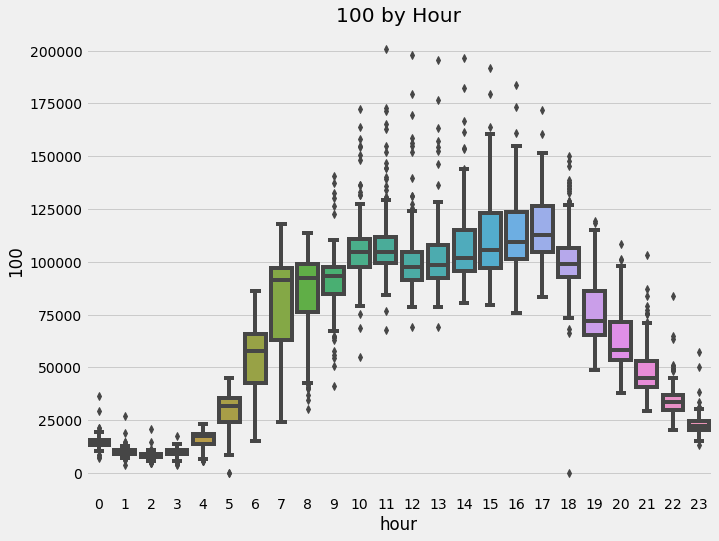

In [105]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_feature, x='hour', y='100')
ax.set_title('100 by Hour')
plt.show()

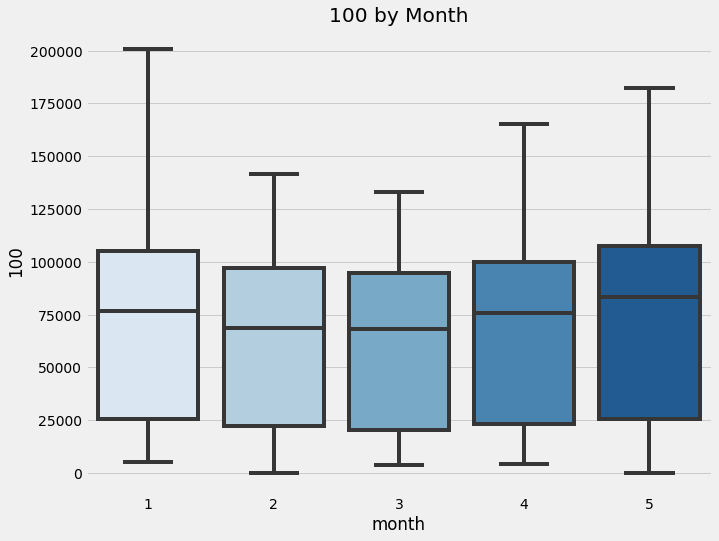

In [106]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_feature, x='month', y='100', palette= 'Blues')
ax.set_title('100 by Month')
plt.show()

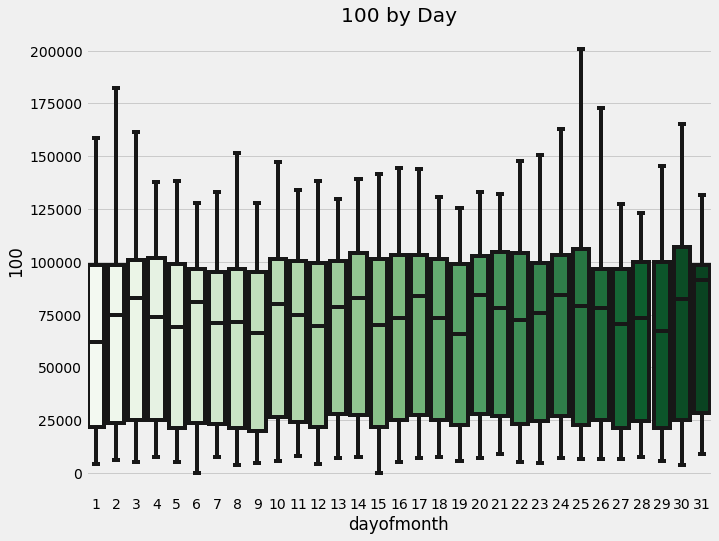

In [107]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_feature, x='dayofmonth', y='100', palette= 'Greens')
ax.set_title('100 by Day')
plt.show()

#Creat the model


In [21]:
# df = create_features(df)
# val = create_features(val)
# test = create_features(test)

In [108]:
#Feature와 Target을 설정해주는 함수 
#ex)'10'의 통행량을 예측하기 위해 나머지 Feature가 사용되는 구조

def makeF(df,i):
  FEATURES = df.drop(df.iloc[:,i].name, axis=1).columns.tolist()
  return FEATURES
def makeT(df,i):
  TARGET = df.iloc[:,i].name
  return TARGET

In [109]:
df.iloc[:,3].name

'100'

In [110]:
train_sh = pd.concat([train,val])

In [111]:
train_sh

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
2020-01-01 01:00:00,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2020-01-01 02:00:00,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
2020-01-01 03:00:00,20200101,3,53290,13753,2270,4242,1021,790,21322,909,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
2020-01-01 04:00:00,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24 19:00:00,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,...,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
2020-05-24 20:00:00,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,...,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
2020-05-24 21:00:00,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,...,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041


In [132]:
train_drop = train.shift(7*24, axis=0).dropna()
test_drop = test.reset_index(drop=True)

In [233]:
test_drop =val.tail(7*24).reset_index(drop=True)
test_drop['date'] = test.reset_index(drop=False)['date']
test_drop = test_drop.set_index('date')

In [273]:
test_drop

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
date,,,,,,,,,,,,,,,,,,,,,
2020-05-25 00:00:00,20200518,0,82065,15172,1500,3294,1086,962,28931,1103,...,618,2790,5147,4331,1329,3665,404,2242,1619,2314
2020-05-25 01:00:00,20200518,1,51248,9840,813,2356,696,546,17888,720,...,430,1864,3269,2561,921,2081,272,1390,1003,1766
2020-05-25 02:00:00,20200518,2,39026,7894,760,2413,408,549,13357,498,...,322,1313,2765,1931,920,1764,228,1136,922,1309
2020-05-25 03:00:00,20200518,3,40993,10137,780,2701,420,741,15544,532,...,326,1766,3320,2060,892,2447,337,1495,975,1912
2020-05-25 04:00:00,20200518,4,77863,19603,1276,5019,968,1160,32101,968,...,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 19:00:00,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,...,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
2020-05-31 20:00:00,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,...,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
2020-05-31 21:00:00,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,...,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041


In [240]:
def makeXGBoost(i):
  X_train = train_sh[makeF(train_sh,i)]
  y_train = train_sh[makeT(train_sh,i)]

  # X_val = val[makeF(i)]
  # y_val = val[makeT(i)]
  X_test = test_drop[makeF(test_drop,i)]
  y_test = test_drop[makeT(test_drop,i)]
  reg = xgb.XGBRegressor(n_estimators = 2000,
                        learning_rate = 0.005)
  reg.fit(X_train, y_train, 
          # eval_set=[(X_train, y_train)], (X_val,y_val),
          verbose=100)
  test[df.iloc[:,i].name] = reg.predict(X_test)
  
  return test

In [241]:
makeXGBoost(2)

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
date,,,,,,,,,,,,,,,,,,,,,
2020-05-25 00:00:00,20200525,0,79654.195312,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-25 01:00:00,20200525,1,48641.933594,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-25 02:00:00,20200525,2,37256.332031,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-25 03:00:00,20200525,3,42530.359375,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-25 04:00:00,20200525,4,77521.679688,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 19:00:00,20200531,19,311915.062500,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-31 20:00:00,20200531,20,298282.593750,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2020-05-31 21:00:00,20200531,21,297762.781250,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [247]:
from tqdm import tqdm
with tqdm(total=len(train_sh.columns)) as pbar:
    for i in range(2,len(train_sh.columns)):
          makeXGBoost(i)
          pbar.update(1)
        


 35%|███▌      | 35/100 [24:13<44:58, 41.52s/it]  


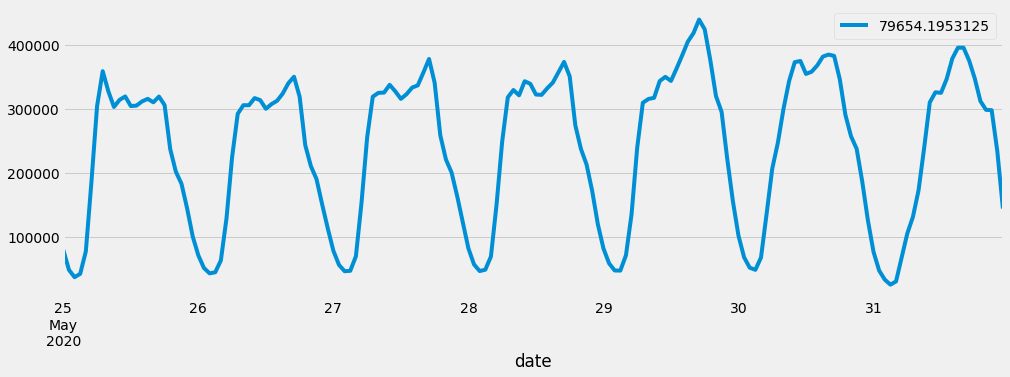

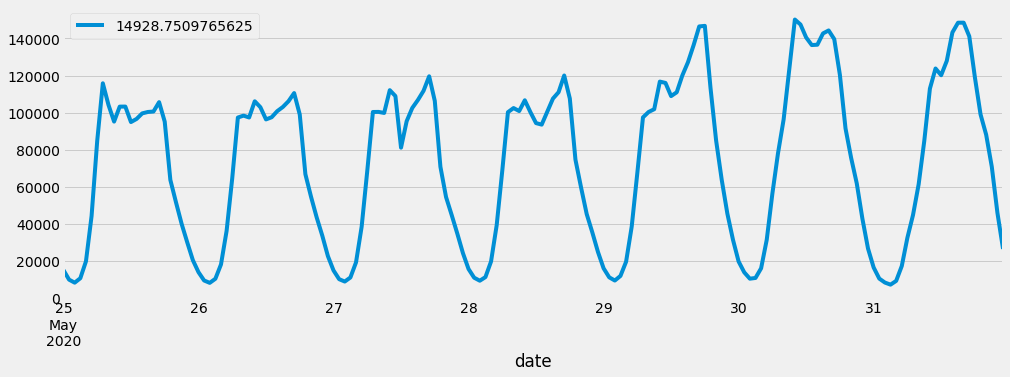

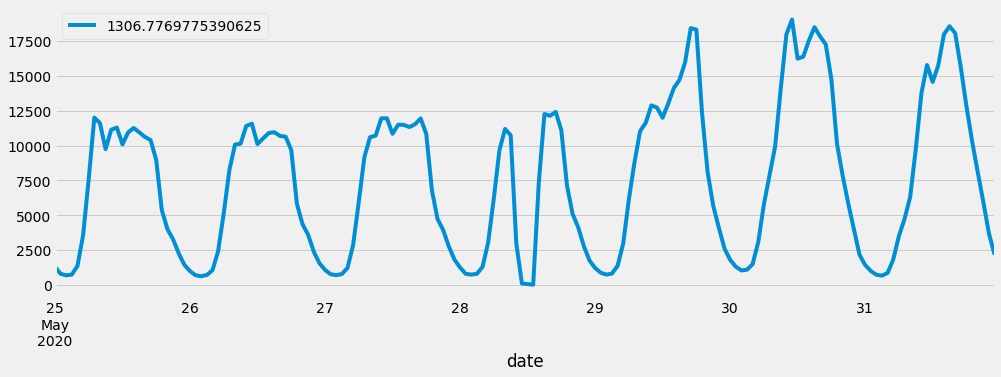

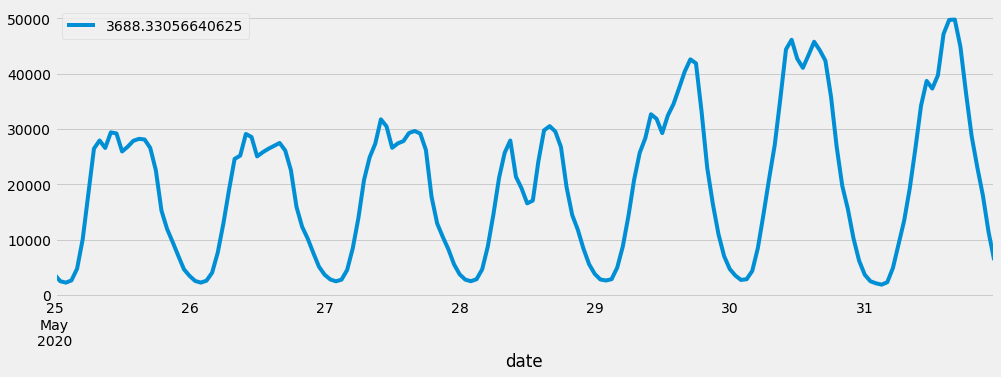

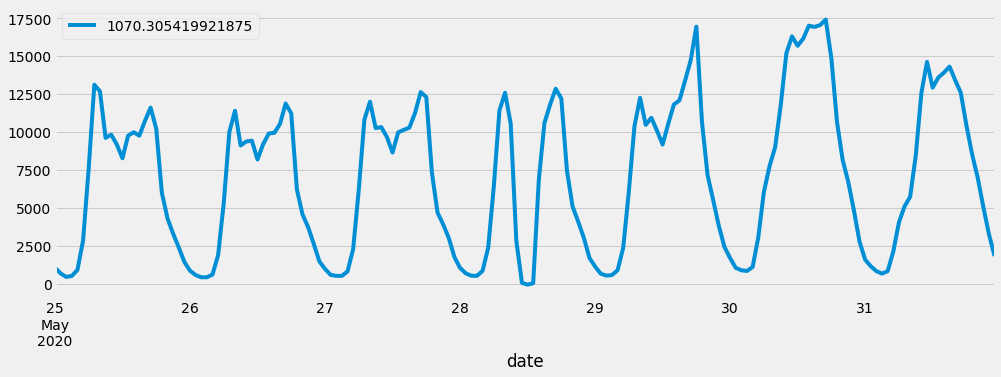

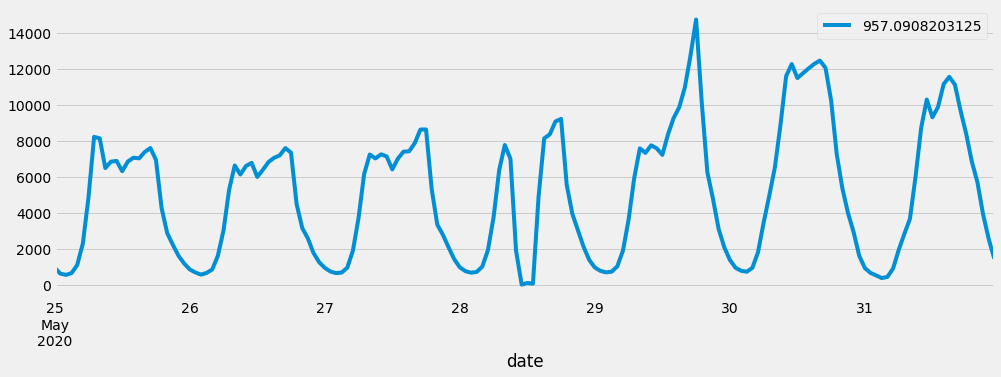

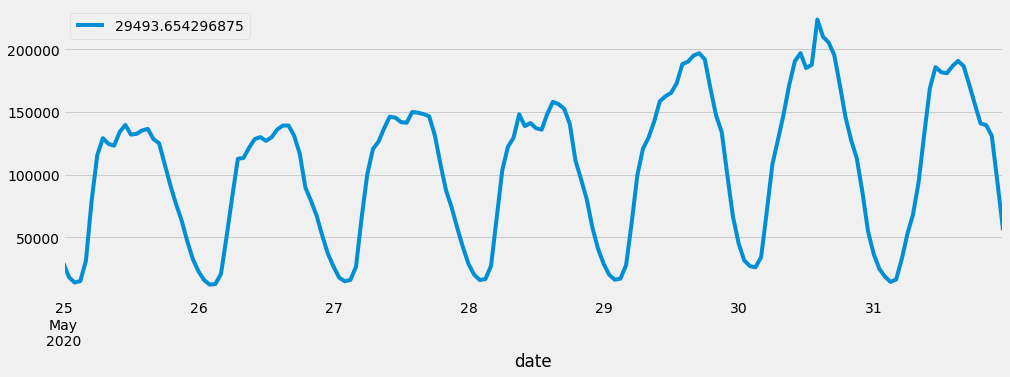

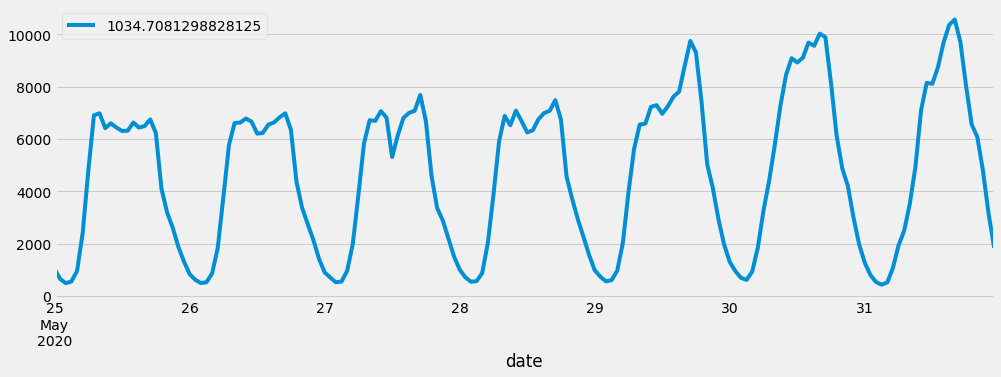

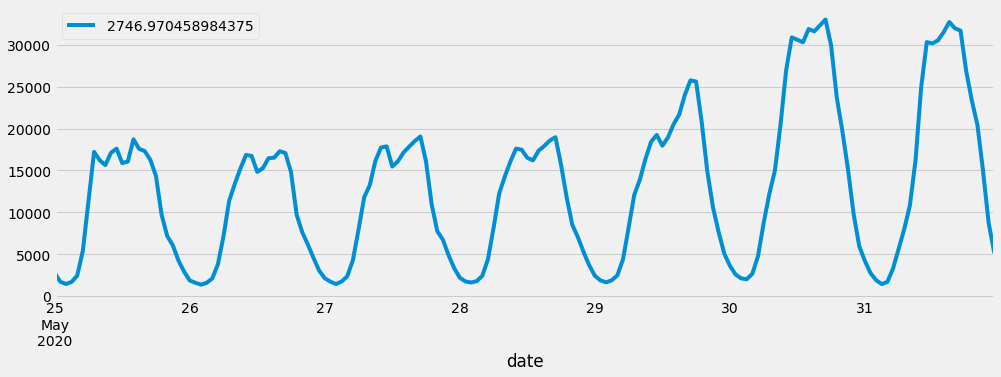

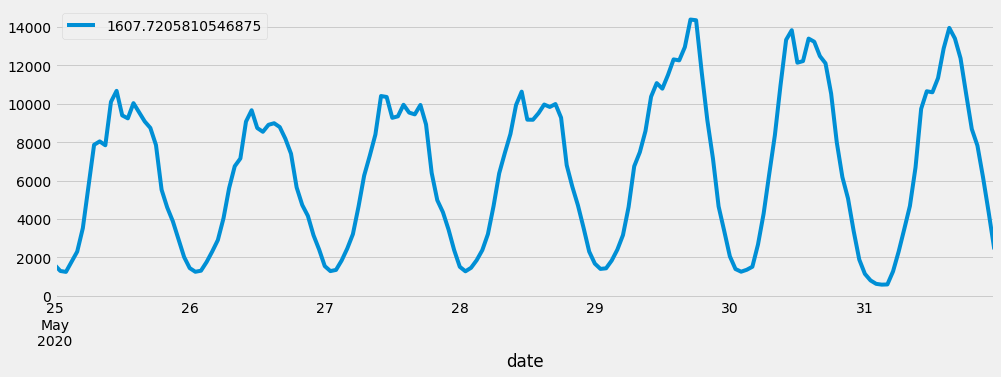

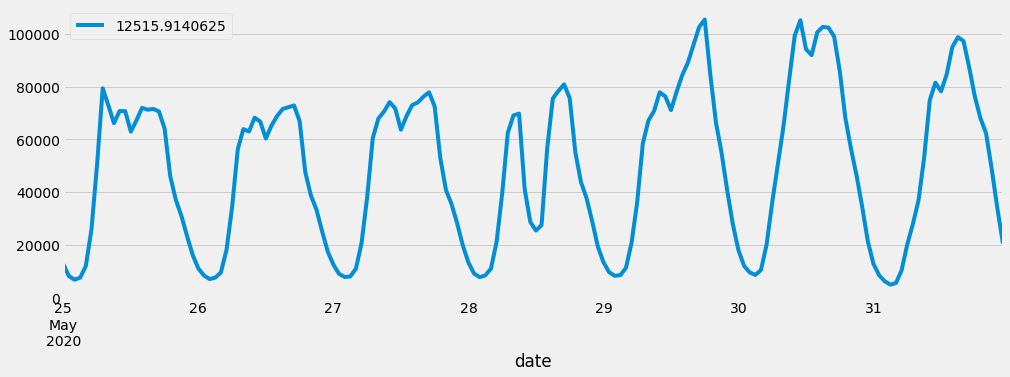

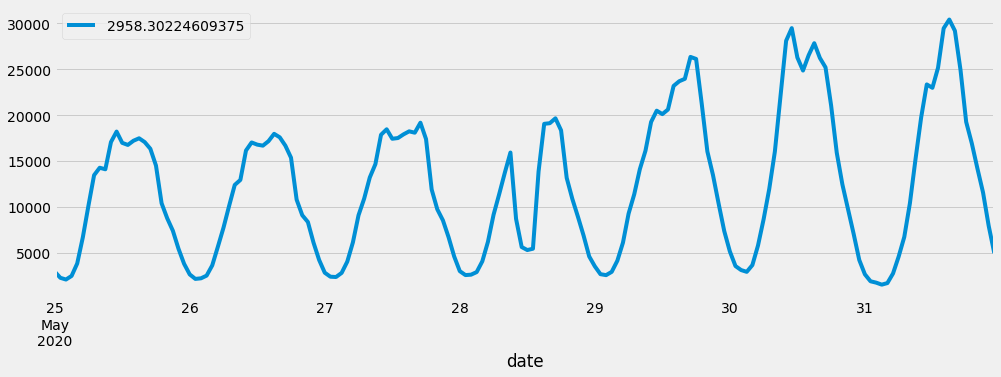

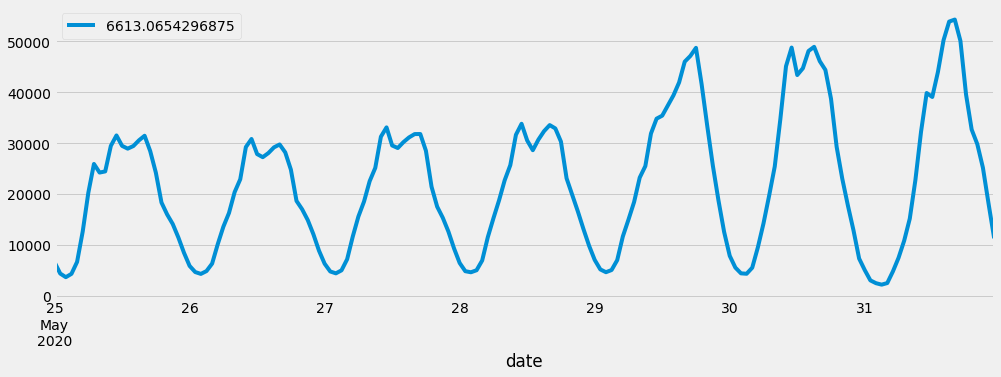

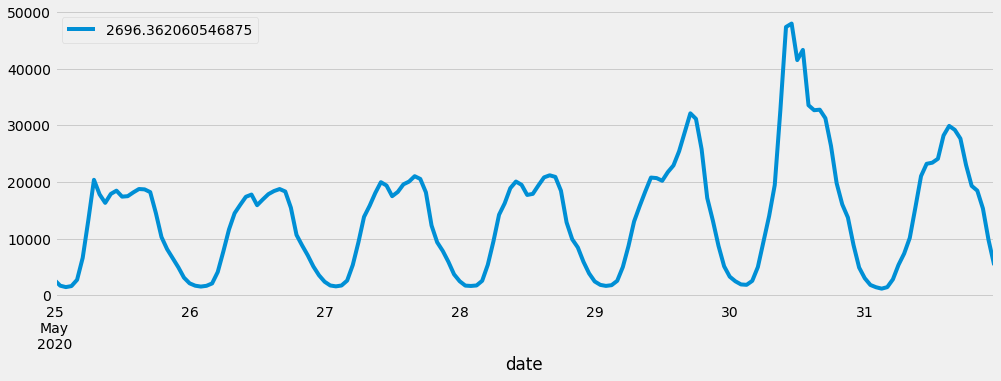

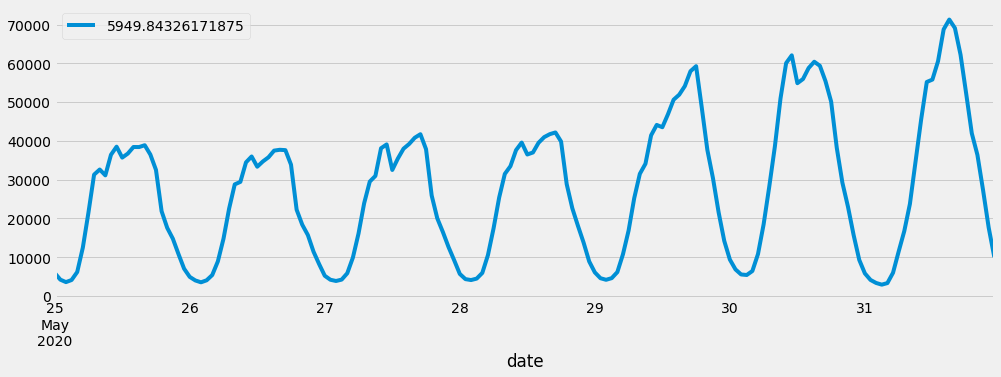

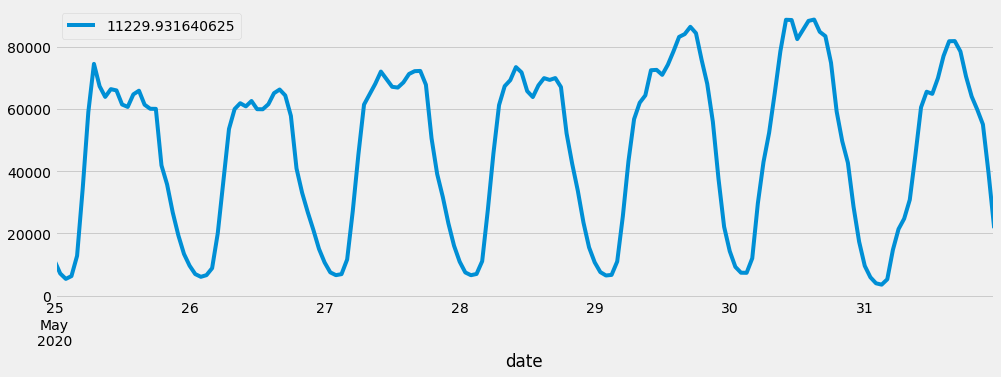

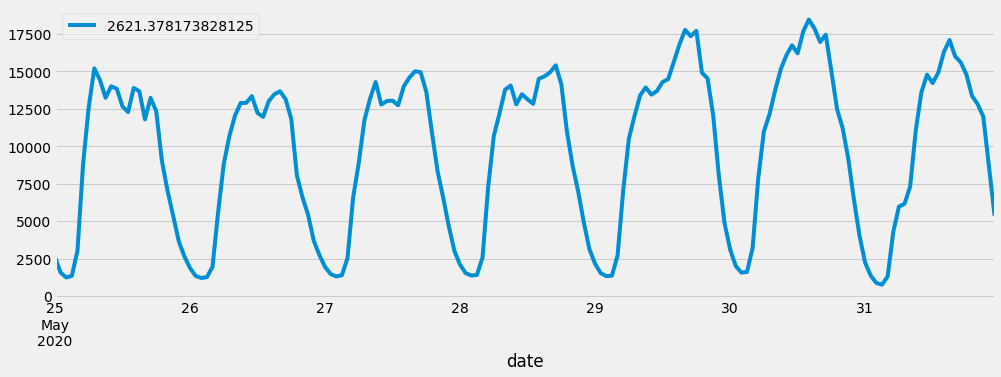

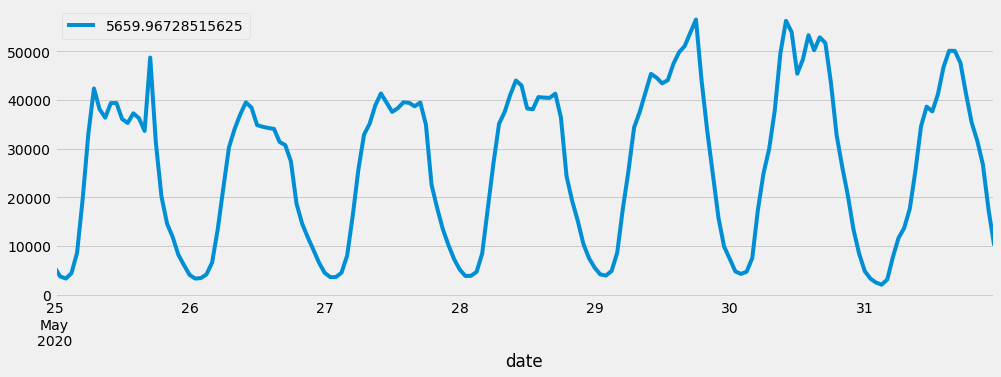

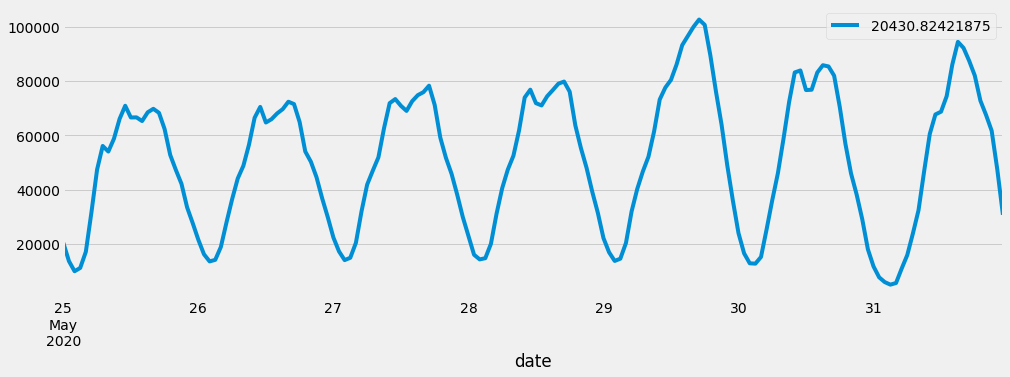

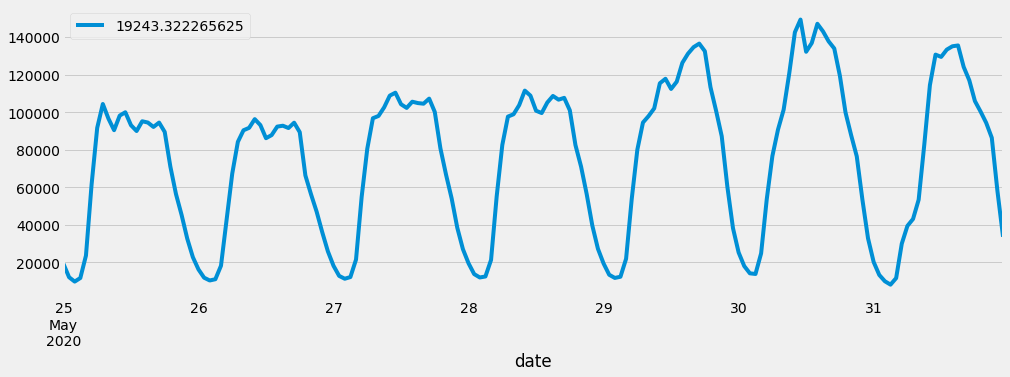

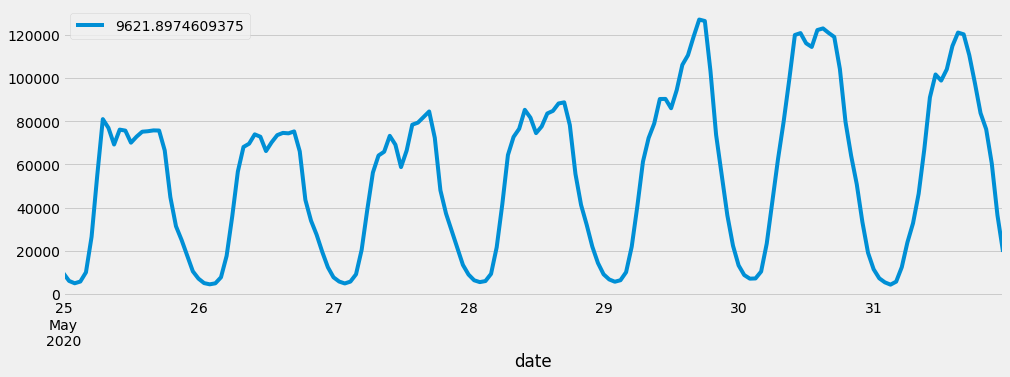

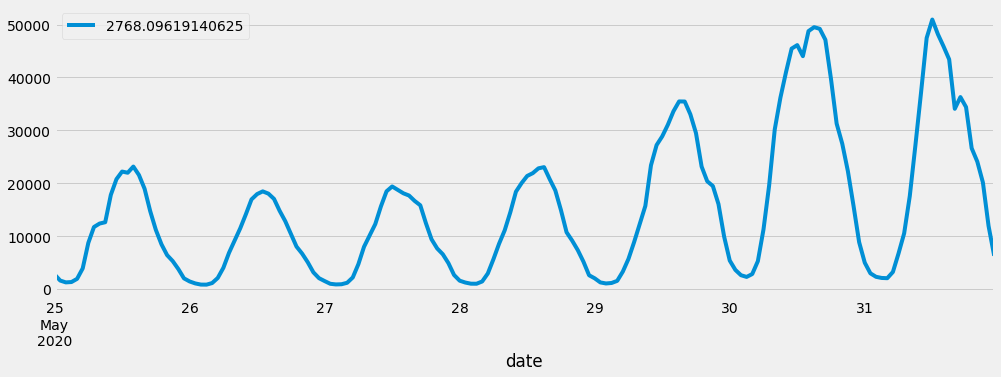

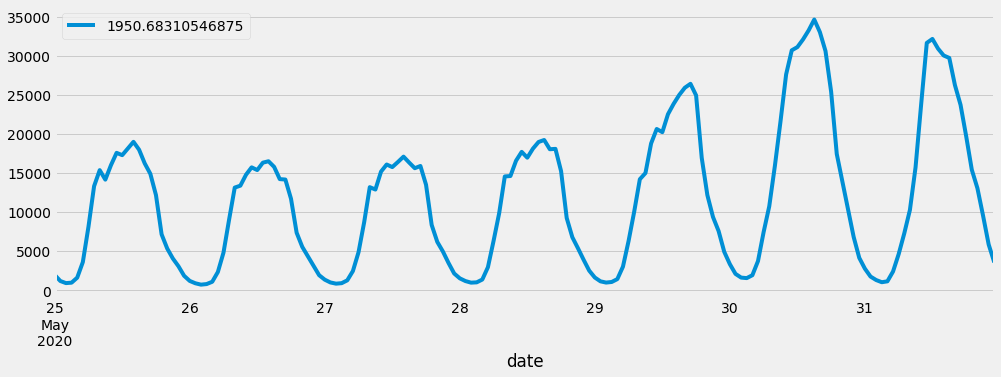

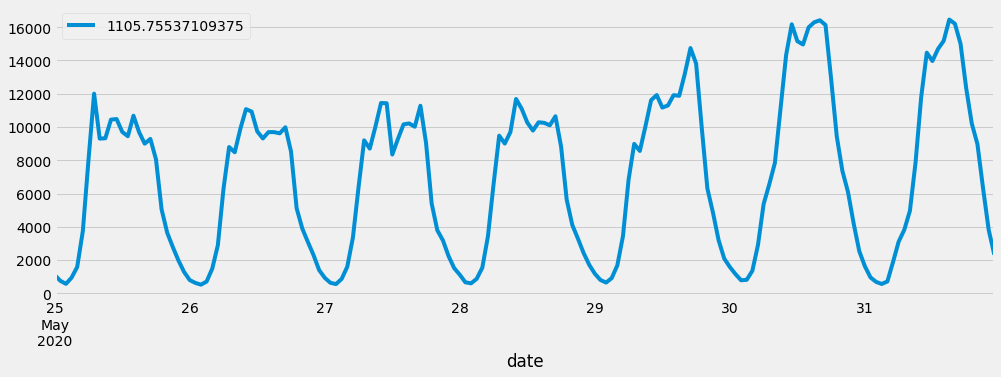

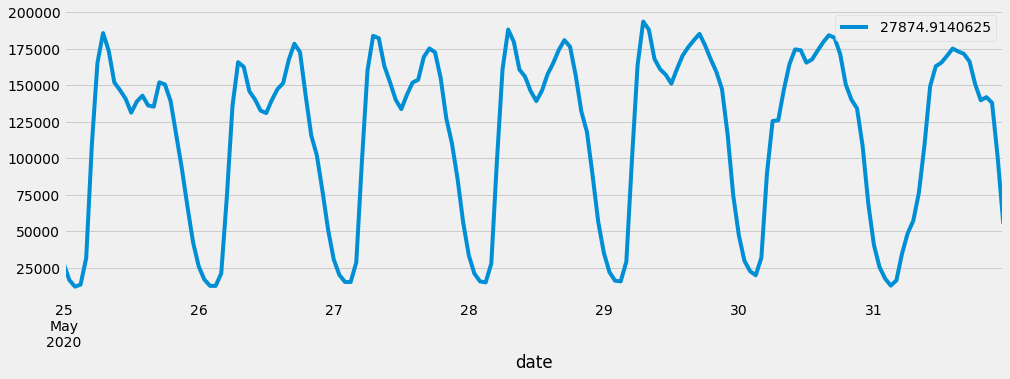

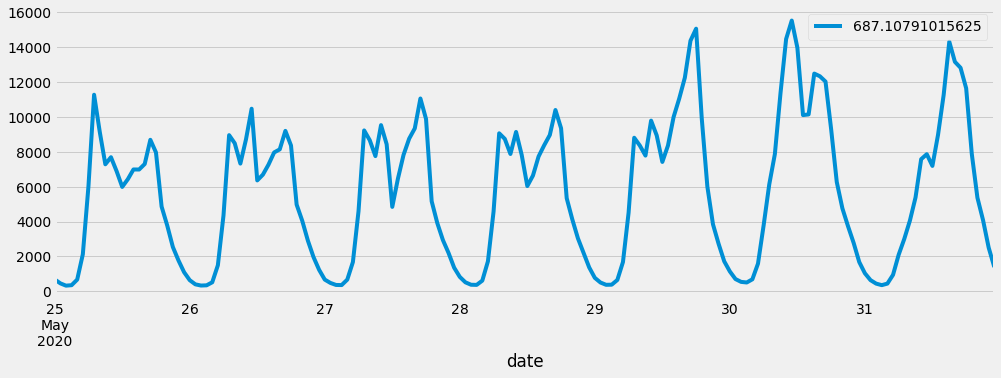

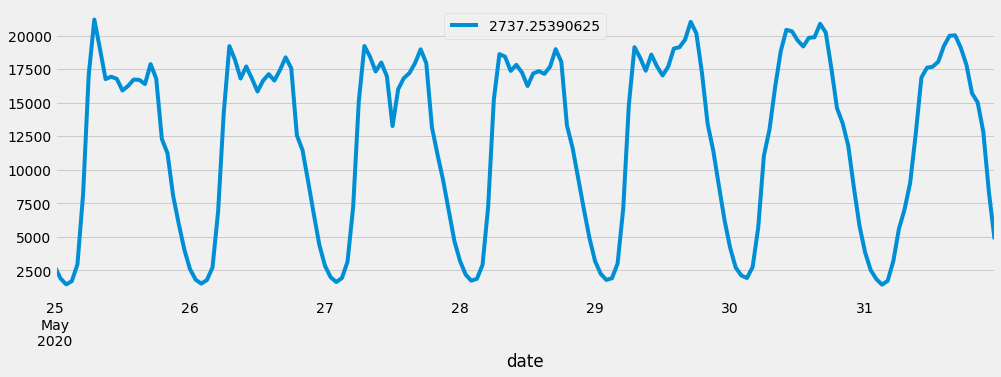

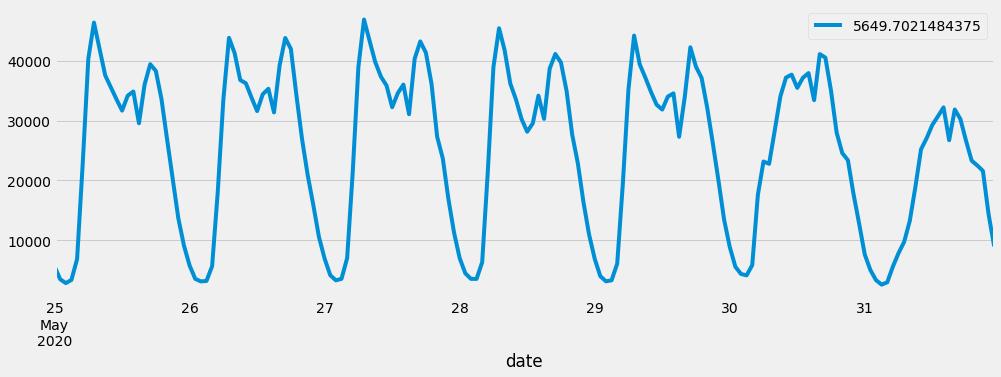

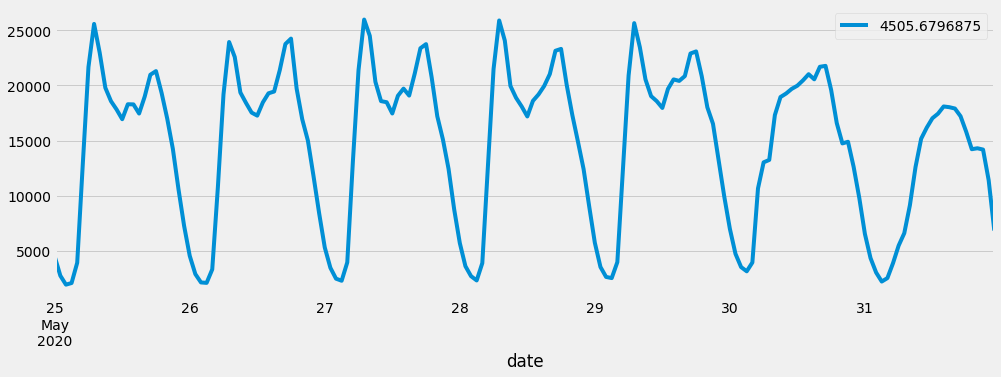

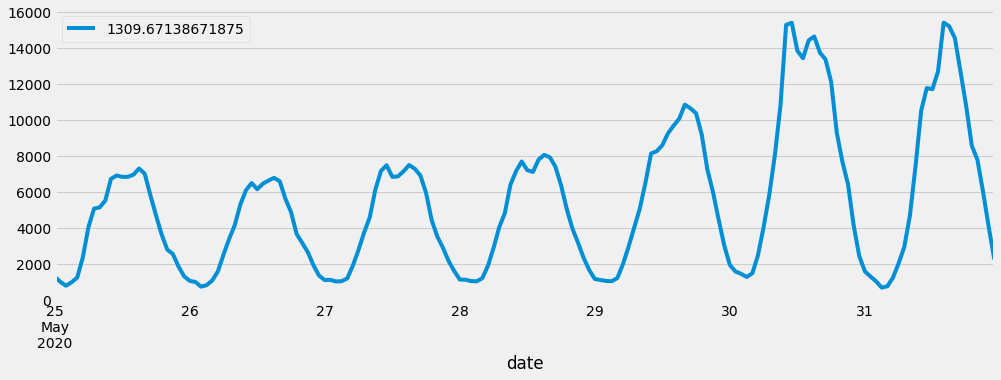

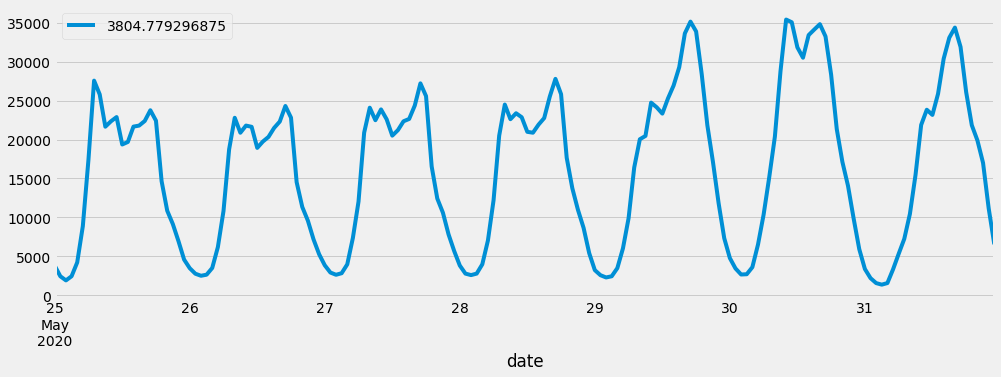

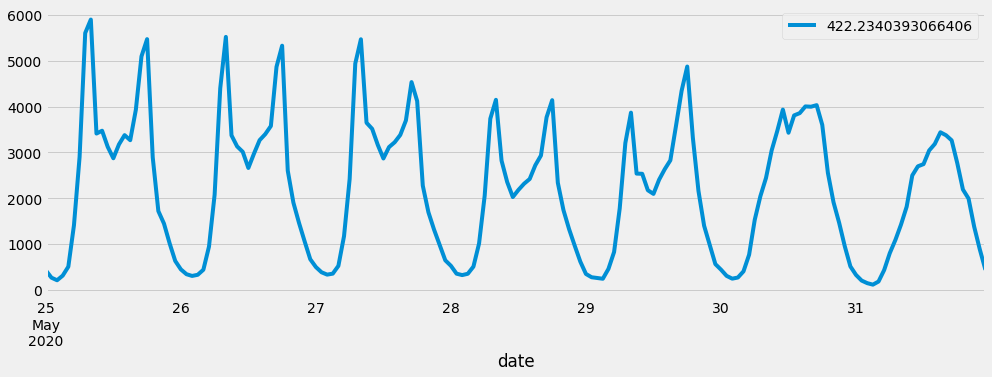

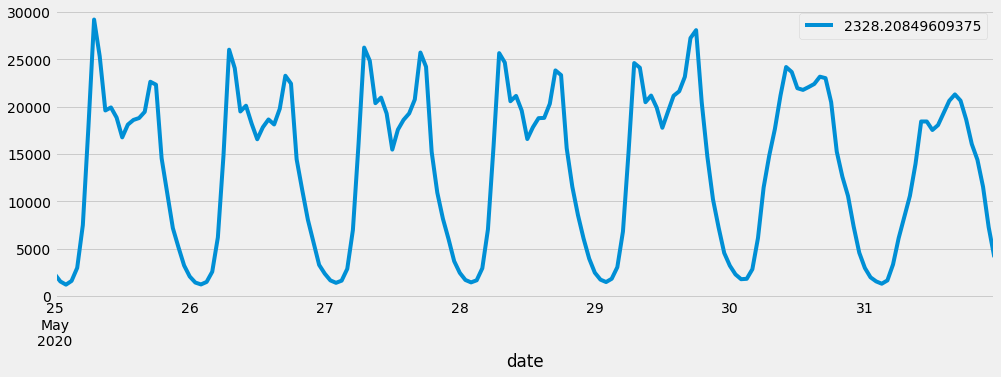

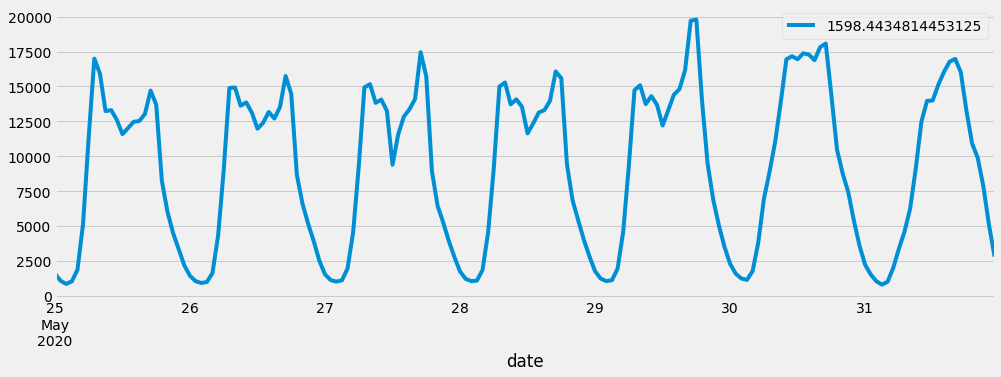

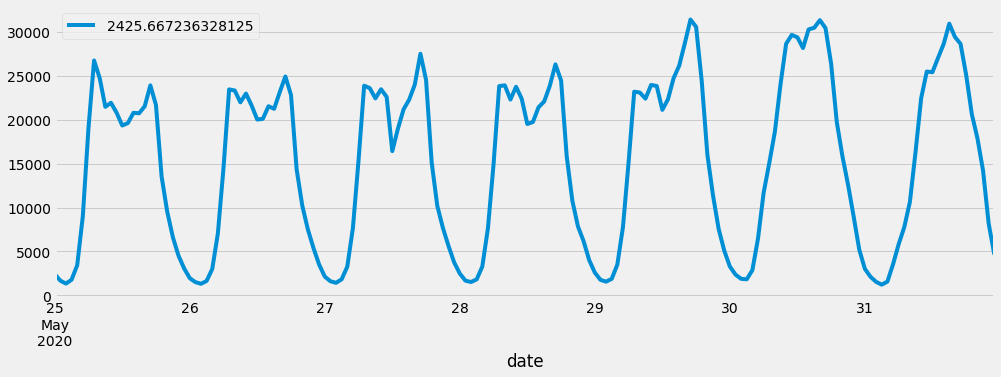

In [249]:
for i in range(2,len(train_sh.columns)):
    test.iloc[:,i].plot(figsize=(15,5))
    plt.legend(test.iloc[:,i])
    plt.show()

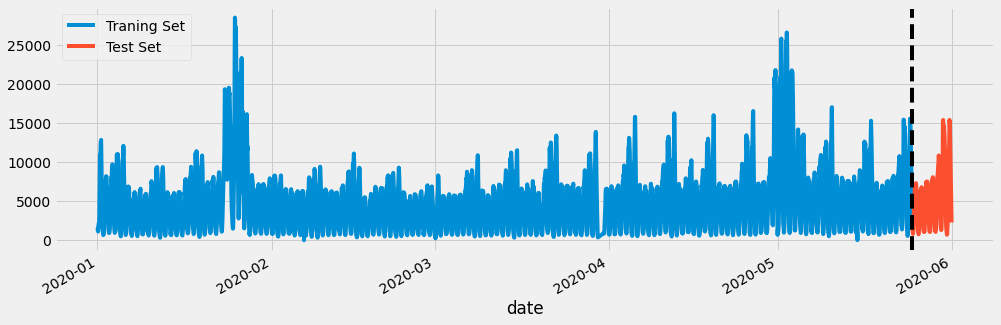

In [274]:
train_sh = pd.concat([train,val])
train_10 = train_sh['1510']
test_10 = test['1510']

fig, ax = plt.subplots(figsize=(15,5))
train_10.plot(ax=ax, label='Training Set')
test_10.plot(ax=ax, label='Test Set')
ax.axvline('2020-05-25', color='black', ls='--')
ax.legend(['Traning Set', 'Test Set'])  
plt.show()

In [252]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)
submission_table.iloc[:,1:] = test.reset_index(drop=True).iloc[:,2:]

In [262]:
submission_table.to_csv('prediction.csv', index=False)

In [270]:
pd.read_csv('/workspace/Competition/TRAFFIC/02_workspace/ver/XGB.prediction.csv', skipinitialspace=True)

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,79654.195,14928.751,1306.7770,3688.3306,1070.30540,957.09080,29493.654,1034.70810,2746.9705,...,687.10790,2737.2540,5649.7020,4505.6797,1309.67140,3804.7793,422.23404,2328.2085,1598.4435,2425.6672
1,20200525_1,48641.934,9732.344,796.2432,2469.1807,685.09955,628.33344,18267.797,651.66300,1708.1940,...,460.24756,1876.5066,3505.6704,2769.9530,1021.94180,2439.7573,262.60065,1546.4907,1073.7701,1679.3813
2,20200525_2,37256.332,8106.107,685.6852,2203.5242,454.88696,558.56670,14087.633,491.11304,1443.9487,...,328.31570,1439.8358,2862.3440,1955.9219,807.86487,1909.6360,205.86652,1207.8633,853.4366,1342.0479
3,20200525_3,42530.360,10505.912,741.4201,2611.2825,516.38370,658.74677,15300.113,559.41595,1686.4352,...,354.46014,1684.4705,3409.1504,2103.3710,998.97750,2443.6262,307.19574,1603.8617,1034.0271,1782.4906
4,20200525_4,77521.680,19625.125,1359.3666,4714.9700,915.89970,1110.46440,31617.360,962.42790,2439.4675,...,675.80750,2929.4077,6868.7676,3939.9026,1259.52990,4216.8970,502.53586,2983.0752,1861.7623,3429.1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,311915.060,99001.730,10341.0590,28672.6600,8553.27050,6853.33450,140964.940,6557.08300,23364.8900,...,7881.54400,15681.8860,23297.3650,14224.1190,8584.39000,21843.0410,2187.71040,16051.9375,10929.0860,20644.9470
164,20200531_20,298282.600,88007.310,8120.9087,23070.4670,7001.68850,5703.34900,139535.250,6083.49850,20431.6840,...,5370.21880,15009.9170,22493.2130,14307.5450,7801.67500,19884.4300,1990.19260,14400.5660,9892.3480,17898.2640
165,20200531_21,297762.780,70697.180,5961.0540,17935.6170,5074.98000,3930.33940,130991.720,4803.22600,14934.5470,...,4083.94290,12819.1880,21591.0400,14190.4120,6026.93950,16999.7170,1376.07410,11540.5010,7873.7610,14213.5290
166,20200531_22,233805.050,45816.945,3700.6035,11363.9630,3277.04000,2558.07470,94238.664,3158.74780,8716.9000,...,2508.45000,8312.6140,14385.4920,11412.8460,4085.92260,11173.6510,879.96500,7279.6090,5104.4870,8176.1284
